In [2]:
import pandas as pd
import numpy as np
import glob, os
import re
import pickle
import datetime as dt
from datetime import datetime

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from numpy import linalg

In [5]:
#sns.color_palette("hls", 8)

In [6]:
data = pickle.load( open( "save.p", "rb" ) )

In [7]:
data.shape

(18309388, 25)

In [8]:
#load other data
plays = pd.read_csv('C:\\Users\\lasha\\Downloads\\Big Data Bowl\\other\\plays.csv')
games = pd.read_csv('C:\\Users\\lasha\\Downloads\\Big Data Bowl\\other\\games_edit.csv')
players = pd.read_csv('C:\\Users\\lasha\\Downloads\\Big Data Bowl\\other\\players_edit.csv')
cov = pd.read_csv('C:\\Users\\lasha\\Downloads\\Big Data Bowl\\other\\coverages_week1.csv')
target = pd.read_csv('C:\\Users\\lasha\\Downloads\\Big Data Bowl\\other\\targetedReceiver.csv')

#### Player EDA

In [9]:
players.columns

Index(['Unnamed: 0', 'nflId', 'height', 'weight', 'birthDate', 'collegeName',
       'position', 'displayName', 'age', 'name_abbrev'],
      dtype='object')

In [10]:
players = players.drop('Unnamed: 0',axis=1)

In [9]:
#players['position'].value_counts()

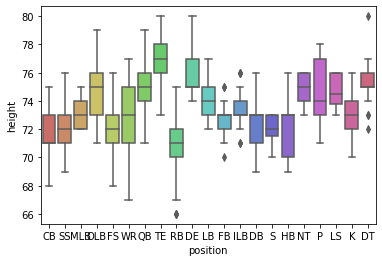

In [10]:
#All positions height
position_height = sns.boxplot(x=players['position'],y=players['height'],palette='hls')
position_height

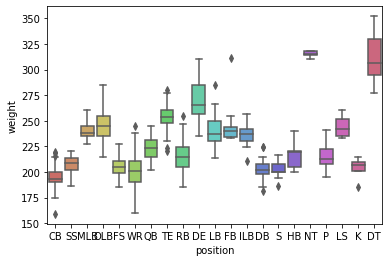

In [11]:
#All positions weight
position_weight = sns.boxplot(x=players['position'],y=players['weight'],palette='hls')
position_weight

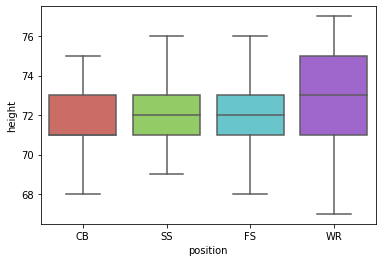

In [12]:
#Narrow to WR, CB, FS, SS
pos_snip = players[players['position'].isin(['WR','CB','FS','SS'])]
snip_height = sns.boxplot(x='position',y='height',palette='hls',data=pos_snip)
snip_height

#### Week 1 Coverage EDA

In [13]:
cov.columns

Index(['gameId', 'playId', 'coverage'], dtype='object')

In [14]:
cov_merge = cov.merge(plays, how='left', on=['gameId','playId'])
cov_merge.shape

(1028, 28)

In [15]:
#Average outcomes of coverage schemes
cov_outcomes_piv = pd.pivot_table(cov_merge, index=['coverage'],values=['offensePlayResult','epa'],aggfunc=np.mean).reset_index()
cov_outcomes_piv.sort_values(by='offensePlayResult')

,coverage,epa,offensePlayResult
7,Prevent Zone,-1.159731,0.000000
0,Cover 0 Man,-0.129566,3.076923
4,Cover 3 Zone,-0.184099,5.426136
5,Cover 4 Zone,-0.038392,5.453947
1,Cover 1 Man,-0.053666,5.621622
3,Cover 2 Zone,0.006339,6.070796
6,Cover 6 Zone,-0.124256,6.681159
2,Cover 2 Man,-0.218558,7.718750


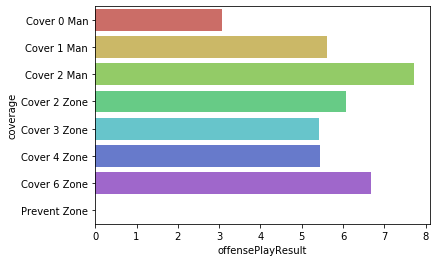

In [16]:
#plot avg result by coverage
sns.barplot(y='coverage',x='offensePlayResult',palette='hls',data=cov_outcomes_piv)

In [17]:
#Def Personnel sets by coverage
cov_defense_piv = pd.pivot_table(cov_merge, index=['coverage','personnelD'],
                                   values=['defendersInTheBox','numberOfPassRushers'])
cov_defense_piv

defendersInTheBox  numberOfPassRushers
coverage     personnelD                                                    
Cover 0 Man  3 DL, 3 LB, 5 DB                 7.000000             8.000000
             3 DL, 4 LB, 4 DB                 8.000000             6.000000
             4 DL, 1 LB, 6 DB                 6.500000             5.500000
             4 DL, 2 LB, 5 DB                 7.250000             5.500000
             4 DL, 3 LB, 4 DB                 7.000000             5.000000
...                                                ...                  ...
Cover 6 Zone 3 DL, 4 LB, 4 DB                 6.800000             4.000000
             4 DL, 1 LB, 6 DB                 3.000000             4.000000
             4 DL, 2 LB, 5 DB                 5.952381             3.904762
             4 DL, 3 LB, 4 DB                 6.777778             4.250000
Prevent Zone 3 DL, 1 LB, 6 DB, 1 TE           4.000000             4.000000

[74 rows x 2 columns]

In [18]:
#coverage by offense formation + results
cov_offense_piv = pd.pivot_table(cov_merge, index=['offenseFormation','coverage'],
                                   values=['offensePlayResult'],aggfunc=np.mean).reset_index()

In [19]:
#ugly chart
# sns.barplot(x='offenseFormation',y='offensePlayResult',hue='coverage',palette='hls',data=cov_offense_piv)

#### Defensive Personnel EDA

In [20]:
#All personnel pivot
d_outcomes_piv = pd.pivot_table(plays, index=['personnelD'],values=['offensePlayResult','epa'],aggfunc=np.mean).reset_index()
#d_outcomes_piv.sort_values(by='offensePlayResult')

In [21]:
#Top 10 personnel pivot .... use clear drop off at top 8 ; top 11 to get 100 plays or more
top_pers_list = plays['personnelD'].value_counts(sort=True,ascending=False).index[:8].to_list()
top_personnel = plays[plays['personnelD'].isin(top_pers_list)]
#top_personnel.shape

In [22]:
topd_outcomes_piv = pd.pivot_table(top_personnel, index=['personnelD'],values=['offensePlayResult','epa'],aggfunc=np.mean).reset_index()
topd_outcomes_piv.sort_values(by='offensePlayResult')

,personnelD,epa,offensePlayResult
5,"4 DL, 1 LB, 6 DB",-0.154433,5.579710
2,"3 DL, 2 LB, 6 DB",-0.146802,5.691500
3,"3 DL, 3 LB, 5 DB",-0.002265,5.979697
1,"2 DL, 4 LB, 5 DB",0.000336,6.076339
0,"2 DL, 3 LB, 6 DB",0.021256,6.279171
6,"4 DL, 2 LB, 5 DB",0.038841,6.316747
4,"3 DL, 4 LB, 4 DB",0.205171,7.358008
7,"4 DL, 3 LB, 4 DB",0.183334,7.388035


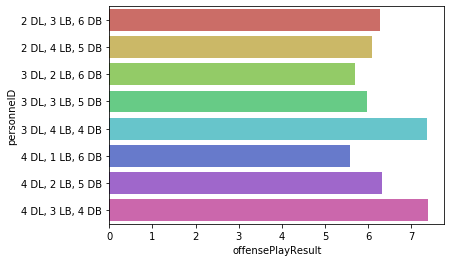

In [23]:
#plot avg result by personnel
sns.barplot(y='personnelD',x='offensePlayResult',palette='hls',data=topd_outcomes_piv)

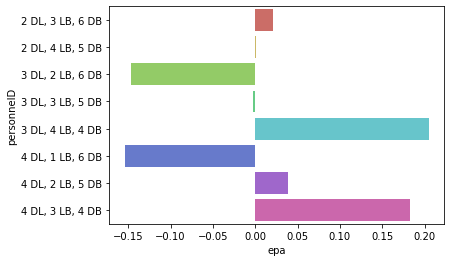

In [24]:
#plot avg epa by personnel
sns.barplot(y='personnelD',x='epa',palette='hls',data=topd_outcomes_piv) #Interesting! but small scale

#### Target Receiver

In [25]:
target.shape

(19239, 3)

In [26]:
target.head()

,gameId,playId,targetNflId
0,2018090600,75,2495454.0
1,2018090600,146,2560854.0
2,2018090600,168,2543583.0
3,2018090600,190,2495454.0
4,2018090600,256,2543583.0


In [27]:
players.head()

,nflId,height,weight,birthDate,collegeName,position,displayName,age,name_abbrev
0,2539334,72,190,1990-09-10,Washington,CB,Desmond Trufant,27.0,D.Trufant
1,2539653,70,186,1988-11-01,Southeastern Louisiana,CB,Robert Alford,29.0,R.Alford
2,2543850,69,186,1991-12-18,Purdue,SS,Ricardo Allen,26.0,R.Allen
3,2555162,73,227,1994-11-04,Louisiana State,MLB,Deion Jones,23.0,D.Jones
4,2555255,75,232,1993-07-01,Minnesota,OLB,De'Vondre Campbell,25.0,De'V.Campbell


In [11]:
#Get player names in target df, then merge into data & plays dfs later
rec_names = players[['nflId','position', 'displayName','name_abbrev']]
target = target.merge(rec_names, how='left', left_on='targetNflId', right_on='nflId')

In [29]:
target.head()

,gameId,playId,targetNflId,nflId,position,displayName,name_abbrev
0,2018090600,75,2495454.0,2495454.0,WR,Julio Jones,J.Jones
1,2018090600,146,2560854.0,2560854.0,WR,Calvin Ridley,C.Ridley
2,2018090600,168,2543583.0,2543583.0,RB,Devonta Freeman,D.Freeman
3,2018090600,190,2495454.0,2495454.0,WR,Julio Jones,J.Jones
4,2018090600,256,2543583.0,2543583.0,RB,Devonta Freeman,D.Freeman


In [30]:
target['position'].value_counts()

WR    10325
TE     3455
RB     3318
QB     1349
FB      135
HB      118
DB        2
CB        2
K         2
DT        1
DE        1
Name: position, dtype: int64

In [31]:
top_target = target['displayName'].value_counts()[:20]
top_target

Antonio Brown          174
Davante Adams          171
Julio Jones            171
JuJu Smith-Schuster    171
DeAndre Hopkins        169
Zach Ertz              161
Michael Thomas         158
Jarvis Landry          154
Travis Kelce           148
Adam Thielen           145
Stefon Diggs           144
Mike Evans             143
George Kittle          136
Robert Woods           133
Keenan Allen           131
Odell Beckham Jr.      130
T.Y. Hilton            129
Kenny Golladay         128
Tyreek Hill            127
Christian McCaffrey    124
Name: displayName, dtype: int64

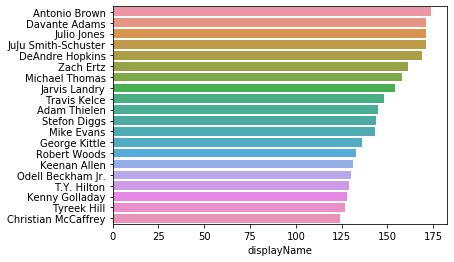

In [32]:
sns.barplot(y=target['displayName'].value_counts()[:20].index, x=target['displayName'].value_counts()[:20])

#### Target + Plays

In [12]:
#merge target with plays df
plays = plays.merge(target.drop('nflId',axis=1), how='left', on = ['gameId','playId'])
plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI,targetNflId,position,displayName,name_abbrev
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,NaN,C,10,10,0.261827,False,2495454.0,WR,Julio Jones,J.Jones
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,...,NaN,I,0,0,-0.372360,False,2560854.0,WR,Calvin Ridley,C.Ridley
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,...,NaN,I,0,0,-0.702779,False,2543583.0,RB,Devonta Freeman,D.Freeman
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,...,NaN,C,33,33,3.047530,False,2495454.0,WR,Julio Jones,J.Jones
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,...,NaN,I,0,0,-0.842272,False,2543583.0,RB,Devonta Freeman,D.Freeman


In [34]:
#Average epa by Targeted Receiver
target_epa = plays.groupby(['displayName'])['epa'].agg('mean')
target_epa

displayName
A.J. Derby       0.608319
A.J. Green       0.406418
AJ McCarron     -0.792213
Aaron Jones      0.102747
Aaron Rodgers   -1.631863
                   ...   
Zach Ertz        0.106111
Zach Line       -0.047136
Zach Pascal     -0.070228
Zach Zenner     -0.071384
Zay Jones       -0.075590
Name: epa, Length: 552, dtype: float64

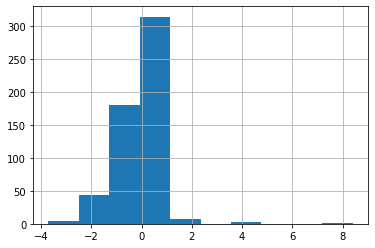

In [35]:
target_epa.hist() #weird outliers. who are they?

In [36]:
#sns.distplot(target_epa)

In [37]:
#top avg epas aka outliers...
target_epa.sort_values(ascending=False)[:10] 
#who on earth is Dane?? 2 Saints! 1 a defender
#need to isolate to get better information --- look at top targets and players with minimum X targets

displayName
Dane Cruikshank      8.397043
Justin Hardee        3.778991
Sam Shields          3.658389
Tyrone Swoopes       2.239733
Tim White            2.083611
Tommylee Lewis       1.770074
Sean Culkin          1.568851
Leonte Carroo        1.510687
D'Onta Foreman       1.278305
Charcandrick West    1.208197
Name: epa, dtype: float64

In [38]:
#top avg epa with at least 50 targets
fifty_targets = plays.groupby(['displayName']).agg('count')
fifty_target_list = fifty_targets[fifty_targets['playId']>50].reset_index()['displayName'].to_list()

In [39]:
plays_fifty_targets = plays[plays['displayName'].isin(fifty_target_list)] 
fifty_target_epa = plays_fifty_targets.groupby(['displayName'])['epa'].agg('mean')
fifty_target_epa.sort_values(ascending=False)

displayName
Tyler Lockett        1.052933
Mark Andrews         0.785705
Mike Williams        0.628514
Tyler Boyd           0.625635
Sammy Watkins        0.606329
                       ...   
Ricky Seals-Jones   -0.483325
Kelvin Benjamin     -0.524454
Deshaun Watson      -1.260036
Dak Prescott        -1.437468
Derek Carr          -1.633701
Name: epa, Length: 126, dtype: float64

In [40]:
#top ten
fifty_target_epa.sort_values(ascending=False)[:10]  #much more reasonable results

displayName
Tyler Lockett     1.052933
Mark Andrews      0.785705
Mike Williams     0.628514
Tyler Boyd        0.625635
Sammy Watkins     0.606329
Cooper Kupp       0.605797
Michael Thomas    0.572570
Josh Gordon       0.539768
T.Y. Hilton       0.534441
Alshon Jeffery    0.516228
Name: epa, dtype: float64

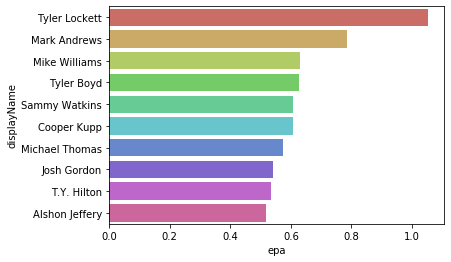

In [41]:
sns.barplot(y=fifty_target_epa.sort_values(ascending=False)[:10].index, x=fifty_target_epa.sort_values(ascending=False)[:10],
           palette='hls')

In [42]:
#Avg epa for top 20 targeted receivers
top_target_list = top_target.index.to_list()
plays_top_target = plays[plays['displayName'].isin(top_target_list)] 
top_target_epa = plays_top_target.groupby(['displayName'])['epa'].agg('mean')
top_target_epa.sort_values(ascending=False) #around 0, not surprising given large amount of targets

displayName
Michael Thomas         0.572570
T.Y. Hilton            0.534441
Kenny Golladay         0.477324
Robert Woods           0.477117
Tyreek Hill            0.457506
George Kittle          0.448216
Travis Kelce           0.444914
Julio Jones            0.428652
DeAndre Hopkins        0.424777
Davante Adams          0.402916
Mike Evans             0.398102
Adam Thielen           0.351171
JuJu Smith-Schuster    0.304182
Keenan Allen           0.285859
Odell Beckham Jr.      0.261583
Christian McCaffrey    0.213947
Zach Ertz              0.106111
Antonio Brown          0.097222
Stefon Diggs          -0.006456
Jarvis Landry         -0.067075
Name: epa, dtype: float64

#### Speed / Acceleration

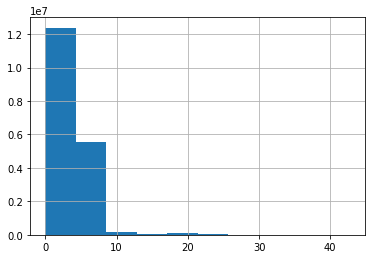

In [43]:
data['s'].hist()

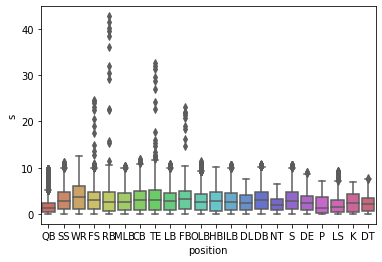

In [44]:
position_speed = sns.boxplot(x=data['position'],y=data['s'],palette='hls')
position_speed

In [45]:
#speed by player (avg and max)
player_avg_speed = data.groupby(['displayName'])['s'].agg('mean')
player_avg_speed.sort_values(ascending=False)[:10]  #Football included - cut these

displayName
A.J. Moore         6.509091
Johnny Holton      5.692356
Dallin Leavitt     5.623514
Football           5.266515
Malachi Dupre      4.960952
Gehrig Dieter      4.940460
Beau Brinkley      4.875354
Brandon Zylstra    4.533180
Markus Wheaton     4.528981
Daniel Brown       4.516344
Name: s, dtype: float64

In [46]:
#speed by player (avg and max)
player_max_speed = data.groupby(['displayName'])['s'].agg('max')
player_max_speed.sort_values(ascending=False)[:10]

displayName
Mark Ingram        42.74
Football           37.32
Josh Hill          32.71
Eric Weddle        24.66
Zach Line          23.17
Benjamin Watson    12.56
Tre'Quan Smith     12.54
T.J. Carrie        11.79
Dallas Goedert     11.58
Jamie Collins      11.34
Name: s, dtype: float64

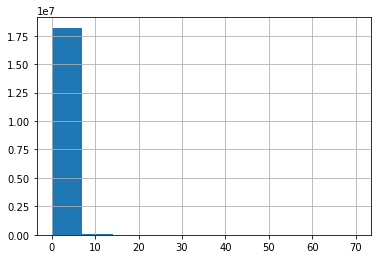

In [47]:
data['a'].hist()

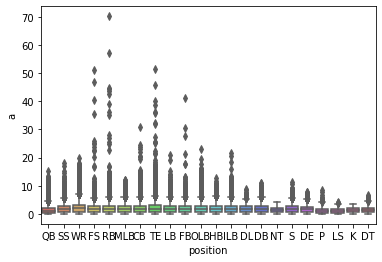

In [48]:
position_accel = sns.boxplot(x=data['position'],y=data['a'],palette='hls')
position_accel

#### DPI in Plays

In [65]:
plays['isDefensivePI'].value_counts()

False    18980
True       259
Name: isDefensivePI, dtype: int64

In [78]:
plays.dtypes

gameId                      int64
playId                      int64
playDescription            object
quarter                     int64
down                        int64
yardsToGo                   int64
possessionTeam             object
playType                   object
yardlineSide               object
yardlineNumber              int64
offenseFormation           object
personnelO                 object
defendersInTheBox         float64
numberOfPassRushers       float64
personnelD                 object
typeDropback               object
preSnapVisitorScore       float64
preSnapHomeScore          float64
gameClock                  object
absoluteYardlineNumber    float64
penaltyCodes               object
penaltyJerseyNumbers       object
passResult                 object
offensePlayResult           int64
playResult                  int64
epa                       float64
isDefensivePI                bool
targetNflId               float64
position                   object
displayName   

In [88]:
plays['isDefensivePI'] = plays['isDefensivePI'].astype(int)

In [89]:
#% of pass plays DPI
(sum(plays['isDefensivePI'])/len(plays[plays['playType']=='play_type_pass']))*100

1.4931396287328491

In [92]:
plays[plays['isDefensivePI']==1]['passResult'].value_counts()

I     231
C      27
IN      1
Name: passResult, dtype: int64

#### Sacks

In [94]:
sacks = plays[plays['passResult']=='S']

In [95]:
#top sacked QBs
sacks['displayName'].value_counts(sort=True)[:10]

Deshaun Watson      65
Dak Prescott        55
Derek Carr          53
Aaron Rodgers       49
Russell Wilson      48
Eli Manning         47
Josh Rosen          45
Matt Ryan           43
Marcus Mariota      43
Matthew Stafford    41
Name: displayName, dtype: int64

In [102]:
#Defensive formations leading to sacks
sack_plays_list = sacks['playId'].to_list()

In [103]:
sack_plays = plays[plays['playId'].isin(sack_plays_list)]
sack_plays['offenseFormation'].value_counts(sort=True)

SHOTGUN       3923
SINGLEBACK     875
EMPTY          725
I_FORM         301
PISTOL          91
WILDCAT         13
JUMBO            9
Name: offenseFormation, dtype: int64

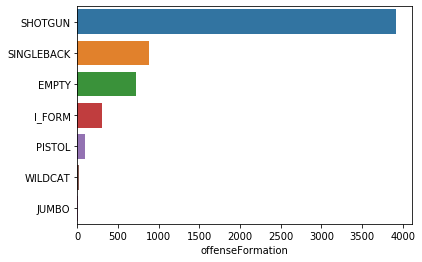

In [104]:
sns.barplot(y=sack_plays['offenseFormation'].value_counts(sort=True).index, x=sack_plays['offenseFormation'].value_counts(sort=True))

In [106]:
#defense personnel/formation
sack_plays['personnelD'].value_counts(sort=True)[:10]

4 DL, 2 LB, 5 DB    2043
3 DL, 3 LB, 5 DB     953
4 DL, 3 LB, 4 DB     738
2 DL, 4 LB, 5 DB     663
4 DL, 1 LB, 6 DB     370
3 DL, 2 LB, 6 DB     325
2 DL, 3 LB, 6 DB     277
3 DL, 4 LB, 4 DB     242
1 DL, 4 LB, 6 DB     103
1 DL, 5 LB, 5 DB      91
Name: personnelD, dtype: int64

In [121]:
#turn into df
sack_df = pd.DataFrame(sack_plays['personnelD'].value_counts(sort=True)[:10]).reset_index()
sack_df.columns = ['personnel', 'sack_count']
sack_df

,personnel,sack_count
0,"4 DL, 2 LB, 5 DB",2043
1,"3 DL, 3 LB, 5 DB",953
2,"4 DL, 3 LB, 4 DB",738
3,"2 DL, 4 LB, 5 DB",663
4,"4 DL, 1 LB, 6 DB",370
5,"3 DL, 2 LB, 6 DB",325
6,"2 DL, 3 LB, 6 DB",277
7,"3 DL, 4 LB, 4 DB",242
8,"1 DL, 4 LB, 6 DB",103
9,"1 DL, 5 LB, 5 DB",91


In [108]:
#in the box
sack_plays['defendersInTheBox'].value_counts(sort=True)

6.0     2747
7.0     1370
5.0     1053
8.0      359
4.0      356
3.0       32
9.0       25
11.0       5
10.0       2
2.0        1
1.0        1
Name: defendersInTheBox, dtype: int64

In [109]:
#pass rushers
sack_plays['numberOfPassRushers'].value_counts(sort=True) #interesting, most sacks with only 4 pass rushers

4.0     3504
5.0     1198
3.0      438
6.0      410
7.0       80
2.0       74
1.0       19
0.0       16
8.0       11
10.0       1
Name: numberOfPassRushers, dtype: int64

In [114]:
#% of time personnel lead to sacks
personnel_sack_list = sack_plays['personnelD'].value_counts(sort=True)[:10].index.to_list()

In [116]:
#count of total plays per personnel set
plays[plays['personnelD'].isin(personnel_sack_list)]['personnelD'].value_counts()

4 DL, 2 LB, 5 DB    6652
3 DL, 3 LB, 5 DB    3103
4 DL, 3 LB, 4 DB    2407
2 DL, 4 LB, 5 DB    2109
4 DL, 1 LB, 6 DB    1104
3 DL, 2 LB, 6 DB    1047
2 DL, 3 LB, 6 DB     917
3 DL, 4 LB, 4 DB     743
1 DL, 4 LB, 6 DB     311
1 DL, 5 LB, 5 DB     266
Name: personnelD, dtype: int64

In [120]:
total_df = pd.DataFrame(plays[plays['personnelD'].isin(personnel_sack_list)]['personnelD'].value_counts()).reset_index()
total_df.columns = ['personnel', 'count']
total_df

,personnel,count
0,"4 DL, 2 LB, 5 DB",6652
1,"3 DL, 3 LB, 5 DB",3103
2,"4 DL, 3 LB, 4 DB",2407
3,"2 DL, 4 LB, 5 DB",2109
4,"4 DL, 1 LB, 6 DB",1104
5,"3 DL, 2 LB, 6 DB",1047
6,"2 DL, 3 LB, 6 DB",917
7,"3 DL, 4 LB, 4 DB",743
8,"1 DL, 4 LB, 6 DB",311
9,"1 DL, 5 LB, 5 DB",266


In [125]:
#Get % of total plays in x personnel result in sack
sack_perc = sack_df.merge(total_df,how='left',on='personnel')
sack_perc['sack_percent'] = (sack_perc['sack_count']/sack_perc['count'] )*100
sack_perc.sort_values(by=['sack_percent'],ascending=False) 
#interesting. sack %s close, highest with 1 DL, 4/5 LB

,personnel,sack_count,count,sack_percent
9,"1 DL, 5 LB, 5 DB",91,266,34.210526
4,"4 DL, 1 LB, 6 DB",370,1104,33.514493
8,"1 DL, 4 LB, 6 DB",103,311,33.118971
7,"3 DL, 4 LB, 4 DB",242,743,32.570659
3,"2 DL, 4 LB, 5 DB",663,2109,31.436700
5,"3 DL, 2 LB, 6 DB",325,1047,31.041070
0,"4 DL, 2 LB, 5 DB",2043,6652,30.712568
1,"3 DL, 3 LB, 5 DB",953,3103,30.712214
2,"4 DL, 3 LB, 4 DB",738,2407,30.660573
6,"2 DL, 3 LB, 6 DB",277,917,30.207197


#### EPA by team - what team has the 'best' def/offense according to EPA

In [126]:
games.head()

,gameId,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,week
0,2018090600,2018-09-06,20:20:00,PHI,ATL,1
1,2018090901,2018-09-09,13:00:00,CLE,PIT,1
2,2018090902,2018-09-09,13:00:00,IND,CIN,1
3,2018090903,2018-09-09,13:00:00,MIA,TEN,1
4,2018090900,2018-09-09,13:00:00,BAL,BUF,1


In [13]:
#Get teams in plays df. then look at 'non-possession' team for defensive epa (lowest avg = best def)
games_snip = games[['gameId','homeTeamAbbr','visitorTeamAbbr']]
plays_wteams = plays.merge(games_snip, how='left', on='gameId')
#plays_wteams.head()

In [14]:
#if possessionTeam == homeabbr, non possessionTeam == visitorabbr
plays_wteams['non_possessTeam'] = np.where(plays_wteams['possessionTeam'] == plays_wteams['homeTeamAbbr'], plays_wteams['visitorTeamAbbr'], plays_wteams['homeTeamAbbr'])
plays_wteams.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,playResult,epa,isDefensivePI,targetNflId,position,displayName,name_abbrev,homeTeamAbbr,visitorTeamAbbr,non_possessTeam
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,10,0.261827,False,2495454.0,WR,Julio Jones,J.Jones,PHI,ATL,PHI
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,...,0,-0.372360,False,2560854.0,WR,Calvin Ridley,C.Ridley,PHI,ATL,PHI
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,...,0,-0.702779,False,2543583.0,RB,Devonta Freeman,D.Freeman,PHI,ATL,PHI
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,...,33,3.047530,False,2495454.0,WR,Julio Jones,J.Jones,PHI,ATL,PHI
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,...,0,-0.842272,False,2543583.0,RB,Devonta Freeman,D.Freeman,PHI,ATL,PHI


In [132]:
#best defenses by avg epa
best_def_piv = pd.pivot_table(plays_wteams, index=['non_possessTeam'],values=['epa'],aggfunc=np.mean).reset_index()
best_def_piv.sort_values(by='epa')[:5]

,non_possessTeam,epa
5,CHI,-0.149298
3,BUF,-0.127225
19,MIN,-0.123750
2,BAL,-0.097879
20,NE,-0.054320


In [134]:
#best offenses by avg epa
best_off_piv = pd.pivot_table(plays_wteams, index=['possessionTeam'],values=['epa'],aggfunc=np.mean).reset_index()
best_off_piv.sort_values(by='epa',ascending=False)[:5]

,possessionTeam,epa
15,KC,0.322556
21,NO,0.257988
16,LA,0.198919
17,LAC,0.152410
1,ATL,0.147390


#### Distance btwn target & nearest defender

In [15]:
#first determine offense and defense in data
defense = ['SS','FS','OLB','CB','LB','ILB','DE','MLB','DT','S','NT','DL','DB']

#0 = offense, 1=defense
data['off_def_bin'] = data['position'].isin(defense).astype(int)
data['off_def']= data['off_def_bin'].apply(lambda x: 'offense' if x==0 else 'defense' )

In [16]:
data = data.drop('off_def_bin',axis=1)

In [17]:
data.head()

,a,dir,dis,displayName,event,file,frameId,gameId,jerseyNumber,nflId,...,team,time,x,y,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,week,off_def
0,0.01,240.93,0.02,Matt Ryan,None,C:\Users\lasha\Downloads\Big Data Bowl\week1.csv,1,2018090600,2.0,310.0,...,away,2018-09-07T01:07:14.599Z,91.73,26.67,2018-09-06,20:20:00,PHI,ATL,1,offense
1,0.01,66.66,0.01,Malcolm Jenkins,None,C:\Users\lasha\Downloads\Big Data Bowl\week1.csv,1,2018090600,27.0,79848.0,...,home,2018-09-07T01:07:14.599Z,88.89,36.47,2018-09-06,20:20:00,PHI,ATL,1,defense
2,0.03,16.86,0.01,Julio Jones,None,C:\Users\lasha\Downloads\Big Data Bowl\week1.csv,1,2018090600,11.0,2495454.0,...,away,2018-09-07T01:07:14.599Z,91.35,44.16,2018-09-06,20:20:00,PHI,ATL,1,offense
3,0.42,168.91,0.01,Corey Graham,None,C:\Users\lasha\Downloads\Big Data Bowl\week1.csv,1,2018090600,24.0,2495613.0,...,home,2018-09-07T01:07:14.599Z,86.31,22.01,2018-09-06,20:20:00,PHI,ATL,1,defense
4,0.00,193.97,0.00,Mohamed Sanu,None,C:\Users\lasha\Downloads\Big Data Bowl\week1.csv,1,2018090600,12.0,2533040.0,...,away,2018-09-07T01:07:14.599Z,90.78,36.15,2018-09-06,20:20:00,PHI,ATL,1,offense


In [57]:
data['off_def'].value_counts()

defense    9605234
offense    8704154
Name: off_def, dtype: int64

In [62]:
data['team'].value_counts()

home        8543264
away        8518482
football    1247642
Name: team, dtype: int64

In [63]:
data[data['off_def']=='offense']['team'].value_counts()

away        3729938
home        3726574
football    1247642
Name: team, dtype: int64

In [64]:
data[data['off_def']=='defense']['team'].value_counts()

home    4816690
away    4788544
Name: team, dtype: int64

In [58]:
data[data['off_def']=='offense']['position'].value_counts()

WR    3399243
TE    1474453
QB    1250063
RB    1247075
FB      42376
HB      40975
P        1017
LS       1017
K         293
Name: position, dtype: int64

In [59]:
data[data['off_def']=='defense']['position'].value_counts()

CB     3475252
OLB    1514644
FS     1287670
SS     1022972
ILB     867365
LB      516954
MLB     425094
DB      366236
S       112963
DE       10732
DL        2567
DT        2399
NT         386
Name: position, dtype: int64

In [136]:
#add target receiver to data
target.head()

,gameId,playId,targetNflId,nflId,position,displayName,name_abbrev
0,2018090600,75,2495454.0,2495454.0,WR,Julio Jones,J.Jones
1,2018090600,146,2560854.0,2560854.0,WR,Calvin Ridley,C.Ridley
2,2018090600,168,2543583.0,2543583.0,RB,Devonta Freeman,D.Freeman
3,2018090600,190,2495454.0,2495454.0,WR,Julio Jones,J.Jones
4,2018090600,256,2543583.0,2543583.0,RB,Devonta Freeman,D.Freeman


In [18]:
data_full = data.merge(target.drop('nflId',axis=1), how='left', on=['gameId','playId'], suffixes=(False, '_target'))

In [19]:
data_full['target_bin'] = (data_full['nflId'] == data_full['targetNflId']).astype(int) 

In [20]:
data_full.head()

,a,dir,dis,displayNameFalse,event,file,frameId,gameId,jerseyNumber,nflId,...,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,week,off_def,targetNflId,position_target,displayName_target,name_abbrev,target_bin
0,0.01,240.93,0.02,Matt Ryan,None,C:\Users\lasha\Downloads\Big Data Bowl\week1.csv,1,2018090600,2.0,310.0,...,20:20:00,PHI,ATL,1,offense,2495454.0,WR,Julio Jones,J.Jones,0
1,0.01,66.66,0.01,Malcolm Jenkins,None,C:\Users\lasha\Downloads\Big Data Bowl\week1.csv,1,2018090600,27.0,79848.0,...,20:20:00,PHI,ATL,1,defense,2495454.0,WR,Julio Jones,J.Jones,0
2,0.03,16.86,0.01,Julio Jones,None,C:\Users\lasha\Downloads\Big Data Bowl\week1.csv,1,2018090600,11.0,2495454.0,...,20:20:00,PHI,ATL,1,offense,2495454.0,WR,Julio Jones,J.Jones,1
3,0.42,168.91,0.01,Corey Graham,None,C:\Users\lasha\Downloads\Big Data Bowl\week1.csv,1,2018090600,24.0,2495613.0,...,20:20:00,PHI,ATL,1,defense,2495454.0,WR,Julio Jones,J.Jones,0
4,0.00,193.97,0.00,Mohamed Sanu,None,C:\Users\lasha\Downloads\Big Data Bowl\week1.csv,1,2018090600,12.0,2533040.0,...,20:20:00,PHI,ATL,1,offense,2495454.0,WR,Julio Jones,J.Jones,0


In [21]:
data_full.shape

(18309388, 31)

In [141]:
data.shape

(18309388, 26)

In [22]:
# actually add in possion / non possession team to full dataset rather than looking to off/def designation by position. 
# likely issues with position bc special teams, and throwing diff players in for the situation. possession safer bet
plays_team_possession = plays_wteams[['gameId','playId','possessionTeam','non_possessTeam']]
data_full = data_full.merge(plays_team_possession, how='left', on=['gameId','playId'])

In [23]:
data_full.shape

(18309388, 33)

In [144]:
data_full.head()

,a,dir,dis,displayNameFalse,event,file,frameId,gameId,jerseyNumber,nflId,...,visitorTeamAbbr,week,off_def,targetNflId,position_target,displayName_target,name_abbrev,target_bin,possessionTeam,non_possessTeam
0,0.01,240.93,0.02,Matt Ryan,None,C:\Users\lasha\Downloads\Big Data Bowl\week1.csv,1,2018090600,2.0,310.0,...,ATL,1,offense,2495454.0,WR,Julio Jones,J.Jones,0,ATL,PHI
1,0.01,66.66,0.01,Malcolm Jenkins,None,C:\Users\lasha\Downloads\Big Data Bowl\week1.csv,1,2018090600,27.0,79848.0,...,ATL,1,defense,2495454.0,WR,Julio Jones,J.Jones,0,ATL,PHI
2,0.03,16.86,0.01,Julio Jones,None,C:\Users\lasha\Downloads\Big Data Bowl\week1.csv,1,2018090600,11.0,2495454.0,...,ATL,1,offense,2495454.0,WR,Julio Jones,J.Jones,1,ATL,PHI
3,0.42,168.91,0.01,Corey Graham,None,C:\Users\lasha\Downloads\Big Data Bowl\week1.csv,1,2018090600,24.0,2495613.0,...,ATL,1,defense,2495454.0,WR,Julio Jones,J.Jones,0,ATL,PHI
4,0.00,193.97,0.00,Mohamed Sanu,None,C:\Users\lasha\Downloads\Big Data Bowl\week1.csv,1,2018090600,12.0,2533040.0,...,ATL,1,offense,2495454.0,WR,Julio Jones,J.Jones,0,ATL,PHI


In [24]:
data_full.rename(columns={'displayNameFalse': 'displayName', 'positionFalse': 'position'}, inplace=True)

In [25]:
data_full.columns

Index(['a', 'dir', 'dis', 'displayName', 'event', 'file', 'frameId', 'gameId',
       'jerseyNumber', 'nflId', 'o', 'playDirection', 'playId', 'position',
       'route', 's', 'team', 'time', 'x', 'y', 'gameDate', 'gameTimeEastern',
       'homeTeamAbbr', 'visitorTeamAbbr', 'week', 'off_def', 'targetNflId',
       'position_target', 'displayName_target', 'name_abbrev', 'target_bin',
       'possessionTeam', 'non_possessTeam'],
      dtype='object')

In [26]:
#players team
data_full['team_name'] = np.where(data_full['team'] == 'away', data_full['visitorTeamAbbr'], data_full['homeTeamAbbr'])

In [27]:
data_full.head()

,a,dir,dis,displayName,event,file,frameId,gameId,jerseyNumber,nflId,...,week,off_def,targetNflId,position_target,displayName_target,name_abbrev,target_bin,possessionTeam,non_possessTeam,team_name
0,0.01,240.93,0.02,Matt Ryan,None,C:\Users\lasha\Downloads\Big Data Bowl\week1.csv,1,2018090600,2.0,310.0,...,1,offense,2495454.0,WR,Julio Jones,J.Jones,0,ATL,PHI,ATL
1,0.01,66.66,0.01,Malcolm Jenkins,None,C:\Users\lasha\Downloads\Big Data Bowl\week1.csv,1,2018090600,27.0,79848.0,...,1,defense,2495454.0,WR,Julio Jones,J.Jones,0,ATL,PHI,PHI
2,0.03,16.86,0.01,Julio Jones,None,C:\Users\lasha\Downloads\Big Data Bowl\week1.csv,1,2018090600,11.0,2495454.0,...,1,offense,2495454.0,WR,Julio Jones,J.Jones,1,ATL,PHI,ATL
3,0.42,168.91,0.01,Corey Graham,None,C:\Users\lasha\Downloads\Big Data Bowl\week1.csv,1,2018090600,24.0,2495613.0,...,1,defense,2495454.0,WR,Julio Jones,J.Jones,0,ATL,PHI,PHI
4,0.00,193.97,0.00,Mohamed Sanu,None,C:\Users\lasha\Downloads\Big Data Bowl\week1.csv,1,2018090600,12.0,2533040.0,...,1,offense,2495454.0,WR,Julio Jones,J.Jones,0,ATL,PHI,ATL


In [28]:
data_full.shape

(18309388, 34)

In [30]:
#PICKLE TO DO DISTANCE IN NEW NOTEBOOK
# pickle.dump(data_full, open( "save2.p", "wb" ) )

In [ ]:
#function to get defender distance from target per play.
# distance = np.sqrt(np.sum(np.square(a - b)))
# dist = np.linalg.norm(a-b)

In [154]:
#get smaller DF for distances
distance_df = data_full[['gameId','playId','frameId','event','nflId','targetNflId','off_def','team_name',
                         'displayName','x','y','displayName_target','target_bin','possessionTeam','non_possessTeam']]

In [155]:
distance_df.head()

,gameId,playId,frameId,event,nflId,targetNflId,off_def,team_name,displayName,x,y,displayName_target,target_bin,possessionTeam,non_possessTeam
0,2018090600,75,1,None,310.0,2495454.0,offense,ATL,Matt Ryan,91.73,26.67,Julio Jones,0,ATL,PHI
1,2018090600,75,1,None,79848.0,2495454.0,defense,PHI,Malcolm Jenkins,88.89,36.47,Julio Jones,0,ATL,PHI
2,2018090600,75,1,None,2495454.0,2495454.0,offense,ATL,Julio Jones,91.35,44.16,Julio Jones,1,ATL,PHI
3,2018090600,75,1,None,2495613.0,2495454.0,defense,PHI,Corey Graham,86.31,22.01,Julio Jones,0,ATL,PHI
4,2018090600,75,1,None,2533040.0,2495454.0,offense,ATL,Mohamed Sanu,90.78,36.15,Julio Jones,0,ATL,PHI


In [158]:
#split possession vs non possession
possession_df = distance_df[distance_df['team_name'] == distance_df['possessionTeam']]
non_possess_df = distance_df[distance_df['team_name'] != distance_df['possessionTeam']]

In [164]:
possession_df_cut = possession_df[['gameId','playId','frameId','nflId','displayName','x','y']]
non_possess_df_cut = non_possess_df[['gameId','playId','frameId','nflId','displayName','x','y']]

In [166]:
match_ups = possession_df_cut.merge(non_possess_df_cut, how='left',on=['gameId','playId','frameId'], 
                                     suffixes=('_off','_def'))

In [ ]:
match_ups.head()

In [175]:
match_ups.shape

(65946757, 11)

In [182]:
# match_ups['off_loc'] =  list(zip(match_ups.x_off, match_ups.y_off))

In [185]:
# match_ups['def_loc'] =  list(zip(match_ups.x_def, match_ups.y_def))

MemoryError: 

In [183]:
match_ups.head()

,gameId,playId,frameId,nflId_off,displayName_off,x_off,y_off,nflId_def,displayName_def,x_def,y_def,off_loc
0,2018090600,75,1,310.0,Matt Ryan,91.73,26.67,79848.0,Malcolm Jenkins,88.89,36.47,"(91.73, 26.67)"
1,2018090600,75,1,310.0,Matt Ryan,91.73,26.67,2495613.0,Corey Graham,86.31,22.01,"(91.73, 26.67)"
2,2018090600,75,1,310.0,Matt Ryan,91.73,26.67,2534832.0,Rodney McLeod,73.64,28.70,"(91.73, 26.67)"
3,2018090600,75,1,310.0,Matt Ryan,91.73,26.67,2552315.0,Jordan Hicks,86.48,31.12,"(91.73, 26.67)"
4,2018090600,75,1,310.0,Matt Ryan,91.73,26.67,2552689.0,Ronald Darby,82.67,20.53,"(91.73, 26.67)"


In [ ]:
match_ups['distance'] = np.sqrt((np.square(match_ups.x_off - match_ups.x_def) + np.square(match_ups.y_off - match_ups.y_def)))

In [ ]:
#then join in target receiver --> closest defender at whatever event